# Facial recognition using Keras and Tensorflow
---

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.__version__

'2.4.1'

######  Load and inspect

In [2]:
from sklearn.datasets import fetch_olivetti_faces


# Load image data into 'sklearn_data' dir in current directory
data_dir = os.path.join(os.getcwd(), 'sklearn_data')
data = fetch_olivetti_faces(data_home=data_dir)
print(f"Image data shape: {data['images'].shape}")

Image data shape: (400, 64, 64)


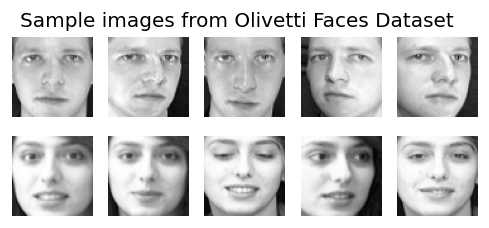

In [3]:
import matplotlib.pyplot as plt

# Plot sample images
rows, cols = 2, 5
fig, ax = plt.subplots(rows, cols, figsize=(5,2), dpi=120)
plt.suptitle('Sample images from Olivetti Faces Dataset')

for i in range(rows):
    for j in range(cols):
            ax[i][j].axis('off')
            ax[i][j].imshow(data['images'][70*i + j], cmap='gist_gray')

###### Preprocess and partition 

In [4]:
# Expand last dimension of array
images = np.expand_dims(data['images'], -1)
print(f"Image data shape: {images.shape}")

Image data shape: (400, 64, 64, 1)


In [5]:
from sklearn.model_selection import train_test_split

# Target labels for images
labels = data['target'].reshape(-1,1)

# Split training/validation data
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, random_state=0, test_size=.1, stratify=labels)

print(f"Training data shape: {X_train.shape}")

Training data shape: (360, 64, 64, 1)


### Build model

In [6]:
tf.keras.backend.clear_session()
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing



# Base sequential model
model = Sequential()

# Add input layer
model.add(Input(shape=images.shape[1:]))

# Add augmentation/preprocessing layers
model.add(preprocessing.RandomRotation(factor=0.01))
model.add(preprocessing.RandomTranslation(height_factor=0.01, width_factor=0.01))
model.add(preprocessing.RandomContrast(factor=0.01))

# Add convolutions/pooling layers
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(16, 5, activation='relu'))
model.add(MaxPooling2D(4, name='pool'))

# Flatten outputs from pooling layer
model.add(Flatten())

# Add fully connected layers seperated by dropouts
model.add(Dense(32, activation='relu'))
model.add(Dropout(.3))

# Final output layer with softmax activaion
model.add(Dense(40, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_rotation (RandomRotat (None, 64, 64, 1)         0         
_________________________________________________________________
random_translation (RandomTr (None, 64, 64, 1)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 16)        12816     
_________________________________________________________________
pool (MaxPooling2D)          (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

###### Compile

In [7]:
from tensorflow.keras.optimizers import Adam


# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

###### Callbacks

In [8]:
# Designate name and path to folder for model checkpoints
filename = 'checkpoints/model.val_accuracy{val_accuracy:.2f}-val_loss{val_loss:.2f}.h5'

# Callbacks to be called during training 
early_stop = tf.keras.callbacks.EarlyStopping(patience=10),
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filename),
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=4, min_lr=1e-5),

### Train model

In [9]:
# Configure training parameters
epochs = 20
batch_size = 16

# Train model
history = model.fit(
    X_train, 
    y_train, 
    verbose=0, 
    epochs=epochs,
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[
               early_stop, 
               checkpoint, 
               reduce_lr,             
])

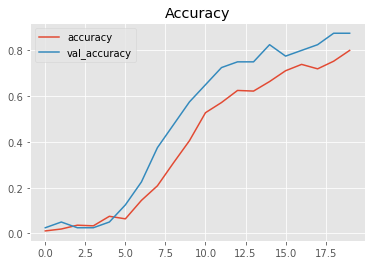

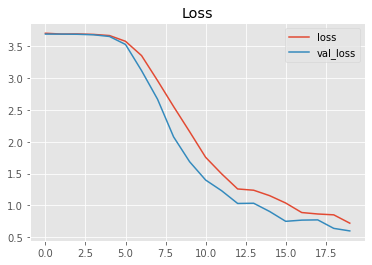

In [10]:
def plot_results():
    # Plot results
    plt.style.use('ggplot')
    hist_df = pd.DataFrame(history.history)
    hist_df[['accuracy','val_accuracy']].plot(title='Accuracy');
    hist_df[['loss','val_loss']].plot(title='Loss');
    
plot_results()

### Further training

Our training/validation losses are is sync, meaning the model is not overfitting
and continued training should help us reach higher accuracies

In [11]:
# Configure training parameters
epochs = 100
batch_size = 12

# Train model
history = model.fit(
    X_train, 
    y_train, 
    verbose=2, 
    epochs=epochs,
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/100
30/30 - 0s - loss: 0.7539 - accuracy: 0.7528 - val_loss: 0.6199 - val_accuracy: 0.8500
Epoch 2/100
30/30 - 0s - loss: 0.6317 - accuracy: 0.7944 - val_loss: 0.5868 - val_accuracy: 0.8750
Epoch 3/100
30/30 - 0s - loss: 0.7057 - accuracy: 0.7917 - val_loss: 0.6879 - val_accuracy: 0.8000
Epoch 4/100
30/30 - 0s - loss: 0.5563 - accuracy: 0.8250 - val_loss: 0.4727 - val_accuracy: 0.9000
Epoch 5/100
30/30 - 0s - loss: 0.5204 - accuracy: 0.8361 - val_loss: 0.4441 - val_accuracy: 0.8750
Epoch 6/100
30/30 - 0s - loss: 0.5786 - accuracy: 0.8278 - val_loss: 0.6202 - val_accuracy: 0.8500
Epoch 7/100
30/30 - 0s - loss: 0.4727 - accuracy: 0.8583 - val_loss: 0.6045 - val_accuracy: 0.8250
Epoch 8/100
30/30 - 0s - loss: 0.4931 - accuracy: 0.8417 - val_loss: 0.6272 - val_accuracy: 0.8500
Epoch 9/100
30/30 - 0s - loss: 0.5121 - accuracy: 0.8333 - val_loss: 0.5239 - val_accuracy: 0.8250
Epoch 10/100
30/30 - 0s - loss: 0.3937 - accuracy: 0.8611 - val_loss: 0.4562 - val_accuracy: 0.8750
Epoch 11/

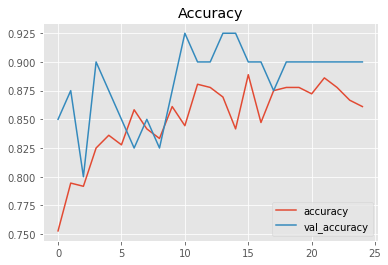

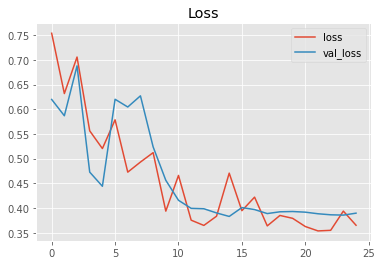

In [12]:
plot_results()

In [17]:
import os

checkpoints = os.listdir('checkpoints')

checkpoints[:3]

['model.val_accuracy0.92-val_loss0.44.h5',
 'model.val_accuracy0.42-val_loss2.06.h5',
 'model.val_accuracy0.25-val_loss3.05.h5']

In [24]:
checkpoints_sorted = []

for ckpt in checkpoints:

    index = ckpt.find("val_accuracy")
    start = index + len("val_accuracy")
    end = start + len("0.00")

    val_accuracy = ckpt[start:end]
    checkpoints_sorted.append((val_accuracy, ckpt))

best_model = sorted(checkpoints_sorted, reverse=True)[0][1]

best_model

'model.val_accuracy0.95-val_loss0.57.h5'

In [30]:
from google.colab import files

files.download(f"checkpoints/{best_model}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>